# Dataset analysis
To generate results for every dataset in the `dataset` folder, run:
```
for dataset in $(find dataset/* -maxdepth 0 -type d); do papermill dataset-info/DatasetBase.ipynb dataset-info/$(basename $dataset).ipynb -p input_dir $dataset; done
```

In [1]:
import matplotlib.pyplot as plt
import re, os
import papermill as pm
%matplotlib inline

In [2]:
# Parameters
input_dir = "dataset/brackets"


In [3]:
# Make a regex to extract dataset name
import re

matchObj = re.match( r'.*/(.*)', input_dir, re.M|re.I)
if matchObj:
    dataset_id = matchObj.group(1)
    dataset_id

In [4]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [5]:
# List files in input_dir in natural order
files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]
files = natural_sort(files)
files[0:5]

['dataset/brackets/2011_12_21_542732180802ce72e4f3dce8b98e47457ccee62d.csv',
 'dataset/brackets/2012_01_31_c3ba4bbc1762453d2536da983ebfba657197af58.csv',
 'dataset/brackets/2012_02_29_ae01487056da4cea33c19f7f360d585283488730.csv',
 'dataset/brackets/2012_03_31_044ee964c4d69238ef8100a3a1c846ae27acd0e1.csv',
 'dataset/brackets/2012_04_30_d3d0de67c1bc732399511e27eeadb89214fc9c43.csv']

In [6]:
import pandas as pd
n_revisions = len(files)
dfs = [pd.read_csv(file) for file in files]

In [7]:
dfs[0].head()

,id,weight
0,c/thirdparty/jstree_pre1.0_fix_1/jquery.jstree.js,4551
1,st/lib/jasmine-core/jasmine.js,2528
2,c/styles/patterns.less,1060
3,st/lib/jasmine-core/jasmine-html.js,676
4,c/styles/forms.less,479


In [8]:
from functools import reduce
# Outer join of files  
df_full = reduce((lambda x, y: pd.merge(x, y, how='outer', on='id')), dfs)

In [9]:
# Rename columns
df_full.columns = ['id'] + ['t'+str(i) for i in range(df_full.shape[1]-1)]

In [10]:
df_full.head()

,id,t0,t1,t2,t3,t4,t5,t6,t7,t8,...,t78,t79,t80,t81,t82,t83,t84,t85,t86,t87
0,c/thirdparty/jstree_pre1.0_fix_1/jquery.jstree.js,4551.0,4551.0,4551.0,4551.0,4551.0,4552.0,4552.0,4552.0,4552.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,st/lib/jasmine-core/jasmine.js,2528.0,2528.0,2528.0,2528.0,2528.0,2528.0,2528.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c/styles/patterns.less,1060.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,st/lib/jasmine-core/jasmine-html.js,676.0,676.0,676.0,676.0,676.0,676.0,676.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c/styles/forms.less,479.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
from collections import defaultdict
import networkx as nx

FILE_MARKER = '<files>'

def attach(branch, trunk):
    parts = branch.split('/', 1)
    if len(parts) == 1:  # branch is a file
        trunk[FILE_MARKER].append(parts[0])
    else:
        node, others = parts
        if node not in trunk:
            trunk[node] = defaultdict(dict, ((FILE_MARKER, []),))
        attach(others, trunk[node])

def build_adjacency_list(d, id, result):
    for key in d.keys():
        if key != FILE_MARKER:
            result.append((id, id + key))
            build_adjacency_list(d[key], id + key, result)
        else:
            for file in d[key]:
                result.append((id, id + file))

        
def plot_tree(id_list):
    
    keys = sorted(id_list)

    main_dict = defaultdict(dict, ((FILE_MARKER, []),))
    for line in keys:
        attach(line, main_dict)

    # _create adjacency list
    result = []
    build_adjacency_list(main_dict, "ROOT", result)

    G = nx.DiGraph()
    G.add_edges_from(result)
    # write dot file to use with graphviz
    # run "dot -_tpng test.dot >test.png"
    # nx.nx_agraph.write_dot(_g, 'test.dot')

    # same layout using matplotlib with no labels
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=False, arrows=False, node_size=2)



## Union tree of all revisions

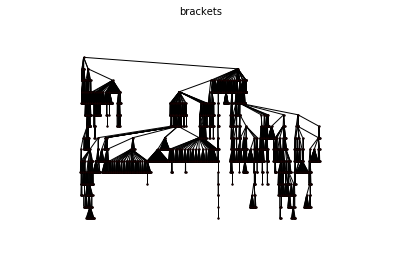

In [12]:
tree_fig = plt.figure(0)
tree_fig.suptitle(dataset_id)
plt.axis('off')
plot_tree(df_full['id'].tolist())
#pm.display('tree', tree_fig)



# Evolution

## Items count

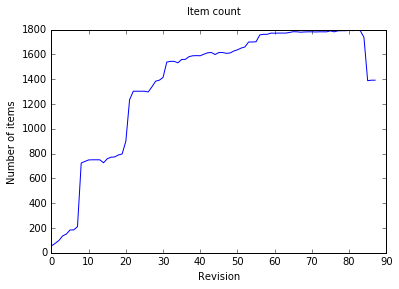

In [13]:
def plot_item_count():
    n_items = [len(df) for df in dfs]
    plt.plot(n_items)

fig = plt.figure()
fig.suptitle("Item count")
plt.ylabel('Number of items')
plt.xlabel('Revision')

plot_item_count()

## Weight count

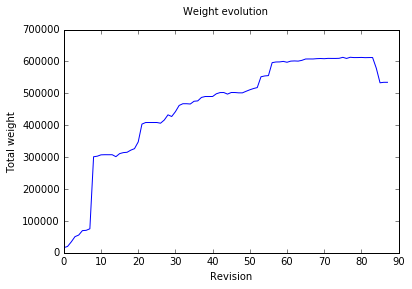

In [14]:
def plot_weight():
    total_weight = [sum(df['weight']) for df in dfs]
    plt.plot(total_weight)

fig = plt.figure()
fig.suptitle("Weight evolution")
plt.ylabel('Total weight')
plt.xlabel('Revision')
plot_weight()

## Addition and removal of items

In [15]:
# How to find removals
pd.merge(dfs[0], dfs[1], on='id', how='outer', indicator=True).query('_merge=="left_only"')

,id,weight_x,weight_y,_merge
2,c/styles/patterns.less,1060.0,NaN,left_only
4,c/styles/forms.less,479.0,NaN,left_only
12,c/styles/mixins.less,222.0,NaN,left_only
13,c/styles/tables.less,224.0,NaN,left_only
16,c/styles/type.less,187.0,NaN,left_only
18,c/styles/brackets.less,172.0,NaN,left_only
21,c/styles/scaffolding.less,139.0,NaN,left_only
22,c/styles/reset.less,141.0,NaN,left_only
38,c/styles/variables.less,60.0,NaN,left_only
46,c/styles/bootstrap.less,30.0,NaN,left_only


In [16]:
# How to find additions
pd.merge(dfs[0], dfs[1], on='id', how='outer', indicator=True).query('_merge=="right_only"')
# len(pd.merge...) to get the number of additions/deletions

,id,weight_x,weight_y,_merge
56,c/styles/bootstrap/patterns.less,NaN,1058.0,right_only
57,c/styles/bootstrap/forms.less,NaN,479.0,right_only
58,c/DocumentManager.js,NaN,628.0,right_only
59,c/brackets.less,NaN,340.0,right_only
60,c/EditorManager.js,NaN,415.0,right_only
61,c/styles/bootstrap/mixins.less,NaN,223.0,right_only
62,c/styles/bootstrap/tables.less,NaN,224.0,right_only
63,c/styles/bootstrap/type.less,NaN,187.0,right_only
64,c/WorkingSetView.js,NaN,253.0,right_only
65,c/FileWatching.js,NaN,189.0,right_only


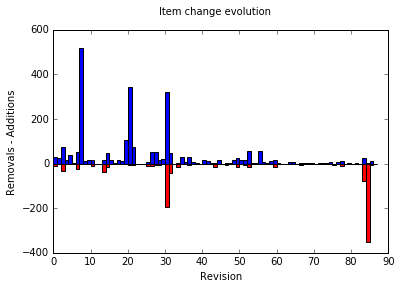

In [17]:
fig, ax = plt.subplots()

n_additions = []
n_removals = []
for i in range(1, n_revisions):
    n_additions.append(
        len(pd.merge(dfs[i-1], dfs[i], on='id', how='outer', indicator=True)
            .query('_merge=="right_only"')))
    n_removals.append(
        -len(pd.merge(dfs[i-1], dfs[i], on='id', how='outer', indicator=True)
            .query('_merge=="left_only"')))
x = range(0, n_revisions - 1)
ax.bar(x ,n_additions, width=1, color='b')
ax.bar(x, n_removals, width=1, color='r')

fig.suptitle("Item change evolution")
plt.ylabel('Removals - Additions')
plt.xlabel('Revision')



## Sum of cell's change in weight (stability)

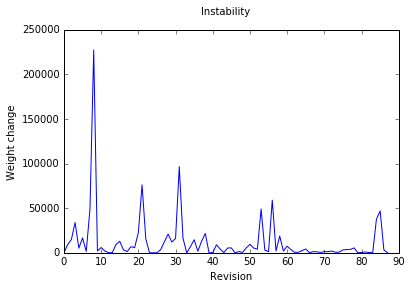

In [18]:
fig = plt.figure()
change = [0.0] * n_revisions
for index, row in df_full.fillna(0).iterrows():
    for j in range (2, len(row)):
        change[j-1] += abs(row[j] - row[j-1])

plt.plot(change)
fig.suptitle("Instability")
plt.ylabel('Weight change')
plt.xlabel('Revision')
    